# Connect Drive and Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.listdir("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025")

['RNA_Seq_transcriptom_meta_data.csv',
 'methylation_data.csv',
 'methylation_data_meta.csv',
 'rna_seq_meta.csv',
 'rna_seq_expr.csv',
 'proteomics_data_meta.csv',
 'proteomics_data.csv',
 'processed_data',
 'proteom_processed_data.csv',
 'methylation_processed_data.csv',
 'mirna_data.csv',
 'mirna_meta.csv',
 'miran_preprocessd.csv',
 'proteomics_processed_data.csv',
 'rna_processed_data.csv']

In [4]:
df_rna = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/rna_processed_data.csv")
df_mirna = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/miran_preprocessd.csv")
df_meth = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/methylation_processed_data.csv")
df_proteom = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/proteomics_processed_data.csv")

In [5]:
df_rna.shape, df_mirna.shape, df_meth.shape, df_proteom.shape

((471, 1001), (448, 1001), (472, 1001), (351, 1001))

## Concatinate Omics Dataset Vertically

In [6]:
df = pd.concat([df_rna, df_mirna, df_meth, df_proteom], axis = 0)
df.shape

(1742, 1001)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Sample_type
0,16.263203,0.327299,0.000000,19.769138,1.581432,1.269175,5.351663,5.258758,2.957267,2.212316,...,0.000000,12.406640,21.054990,4.604846,0.000000,0.000000,0.0,7.330823,13.886055,1
1,0.000000,4.739954,6.203649,0.000000,0.000000,4.964786,0.000000,0.000000,0.000000,0.000000,...,8.739338,0.000000,0.000000,0.000000,5.880862,4.467977,0.0,0.000000,0.000000,1
2,7.760679,8.664506,0.000000,5.489813,0.000000,12.020173,3.703621,0.000000,0.000000,0.000000,...,0.000000,3.664126,6.922591,0.000000,7.129135,0.000000,0.0,7.744801,0.000000,0
3,6.904083,0.000000,0.000000,9.955594,1.360067,0.510893,3.116695,3.584064,2.645634,0.595100,...,0.000000,8.214947,10.884281,4.840510,0.000000,0.000000,0.0,2.877843,7.540813,0
4,0.000000,6.457442,9.758096,0.000000,0.000000,3.386960,0.000000,0.000000,0.000000,0.000000,...,14.779585,0.000000,0.000000,0.000000,6.541218,9.668518,0.0,0.000000,0.000000,1


## Seperatre X and y

In [8]:
X = df.drop("Sample_type", axis = 1)
y = df["Sample_type"]

### Missing Values Checking

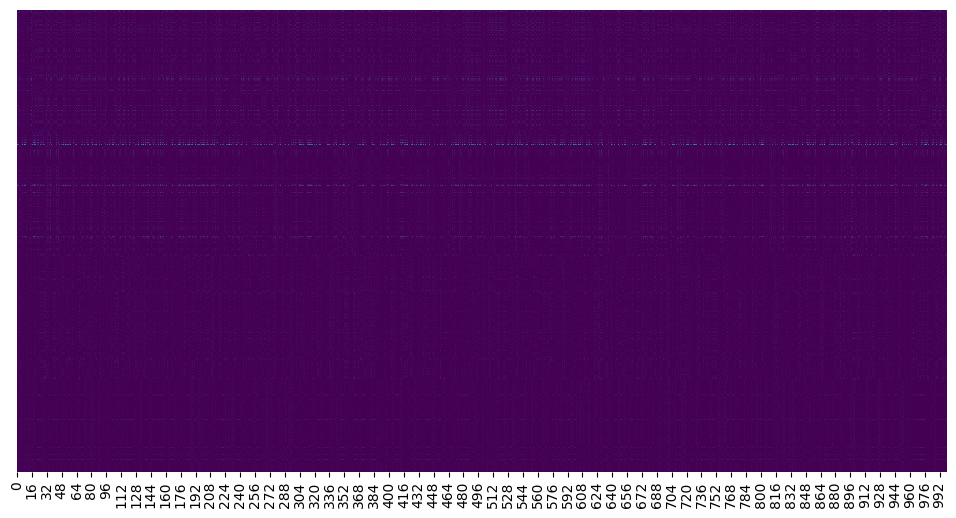

In [9]:
plt.figure(figsize = (12, 6))
sns.heatmap(X, cmap = "viridis", cbar = False, yticklabels=False)
plt.show()

In [10]:
X.isna().sum().sum()

0

## Train Test Split

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim

In [13]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [41]:
X_norm[:2]

array([[0.07924747, 0.0019119 , 0.        , ..., 0.        , 0.07001498,
        0.10355432],
       [0.        , 0.02768823, 0.04929269, ..., 0.        , 0.        ,
        0.        ]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.2, random_state=42)

In [16]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train.to_numpy())
y_test_tensor = torch.LongTensor(y_test.to_numpy())

## Data Loader

In [17]:
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

### Device Agnostic Code

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Transformer Model

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GeneTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.3):
        super(GeneTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=nhead,
                                                    dim_feedforward=dim_feedforward,
                                                    dropout=dropout,
                                                    activation="gelu",
                                                    batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)  # Adaptive pooling for better feature aggregation

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
      x = self.embedding(x).unsqueeze(1)  # Reshape to (batch, seq_len=1, d_model)
      x = self.pos_encoder(x)  # Apply positional encoding
      x = self.transformer(x)  # Pass through Transformer layers
      x = self.pooling(x.transpose(1, 2)).squeeze(2)  # Adaptive pooling
      x = self.classifier(x)  # Classifier
      return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [35]:
input_dim = X_train_tensor.shape[1]
classes = len(y_train.unique())
lr = 0.001
model = GeneTransformer(input_dim = input_dim, num_classes=classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [36]:
model

GeneTransformer(
  (embedding): Linear(in_features=1000, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features

## Model Train

In [38]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        # Taking the loss
        losses.append(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.5189
Epoch [2/10], Loss: 0.5107
Epoch [3/10], Loss: 0.5113
Epoch [4/10], Loss: 0.5074
Epoch [5/10], Loss: 0.5280
Epoch [6/10], Loss: 0.5137
Epoch [7/10], Loss: 0.5080
Epoch [8/10], Loss: 0.5023
Epoch [9/10], Loss: 0.5216
Epoch [10/10], Loss: 0.5074


## Loss value plot

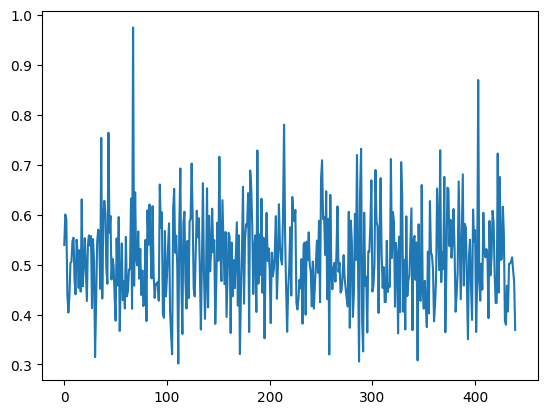

In [40]:
losses2 = []
for los in losses:
  los_detached = los.detach()
  losses2.append(los_detached.numpy())

plt.plot(losses2)

## Inference Mode

In [33]:
def test_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            predicted = torch.argmax(outputs, dim=1)  # Get class predictions

            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run the test loop
test_model(model, test_dataloader)


Test Accuracy: 75.36%
